In [3]:
import pm4py
import pandas as pd
import numpy as np

# pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 200

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
log = pd.read_csv("abstract_log-starts_ends-cov_var_75perc.csv")
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

## Method 2: frequent - simult

took subset of log with only 'candidate' & 'integrated' keywords
why this choice? they all seem to start and end at more or less the same event, with a bunch of spaghetti in between
and, they have similar names ...
so, still kind of considering subprocesses
can still consider replacing all these events with single "sub"event, since they have complicated relations with other events (in particular, auto-promote and such); would lose some information, but who cares

tried frequent itemset mining to get frequent combinations of subset's events
in the end, simply considered all subset's events together
(was mucking about with individual pairs; if simult, ensuring a particular ordering. didn't make much difference & labor intensive.)

with all events taken together, they are "simulteneous" (within 10min) in 75% cases
eventually, removed all "simultaneous" events from the log to get "real" orderings
-> log3

looking at variants _per log subset_ turned out a good idea; zoomed in on certain parts
after checking the discovered petri net & variants, it seemed the following holds, more or less:
cand search:start -> integr search:start -> integr search:end -> cand search:end
 										    cand id:start ~> cand id dec:start -> cand id:end ~> cand id dec:end

used declare miner (RuM tool) - it finds more or less the same constraints; especially when looking at the automaton
but difficult to read ... it seems some of the constraints are inferrable (transitivity; X r Y r Z -> X r Z)
-> search-found-rum-automaton, search-found-rum-constraints

(declarepy goes completely off the deep end for same log; search-found-decl4py-constraints)

manually created a more minimal decl model based on the above
-> search-manual-loose (not fully compliant), search-manual-strict (full compliance)

dcr4py: much better & minimal model - 100% corresponds to hand-drawn one



then, took subset of 'biographic' & 'biometric' events (minus 'fees')
~same criteria for choice as before (perhaps not as clear "start" and "end" events)

not as much luck with simultaneous events
variants (log3) were not very enlightening either

dcr4py: got minimal model that corresponds a bit to inductive miner output (latter when using variants!)



subset of 'medical' events
purely based on labels here

95% of events are simultaneous (within 10 minutes; 92% within 1 minute)
only 8 variants

makes most sense:
(o) Medical:Not Started -> Medical Assessment:Not Started -> Medical:Passed, Medical Assessment:Passed -> (o)
														  -> skip -> (o)



subset of 'criminality'
purely on lablels

only 2 variants; 1 with a coverage of 1
quite simple!

### Candidate / Integrated Search

In [ ]:
log2 = log[(log['concept:name'].str.contains("Candidate")) | log['concept:name'].str.contains("Integrated")]
log2

In [ ]:
import pm4py.objects.log.exporter.xes.exporter as xes_export
xes_export.apply(log2, "zoom-search-all.xes")

In [ ]:
from mine_utils import mine_alpha
mine_alpha(log2)

In [ ]:
traces = log2.groupby('case:concept:name')['concept:name'].apply(tuple).to_list()
traces

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(traces).transform(traces)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

In [ ]:
from mlxtend.frequent_patterns import apriori, fpgrowth

# itemsets = apriori(df, min_support=0.5, use_colnames=True)
itemsets = fpgrowth(df, min_support=0.6, use_colnames=True)
itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
itemsets = itemsets[itemsets['length'] >= 2]
# itemsets.to_csv("itemsets-method2.csv")
itemsets

In [ ]:
itemset = itemsets['itemsets'].iloc[-1]
itemset

In [ ]:
from mine_utils import aggregate_events

# itemset = ('Integrated Search:end', 'Candidate Search:end')
# 13,0.9998259658893143,"frozenset({'Candidate Search:end', 'Integrated Search:end'})",2
# groups: 5746 total size: 11491 avg size: 1.9998259658893143
# groups: 5746 # simult: 5746 avg: 100.0 %
# groups: 5746 avg_diff: 1980 s ( 33 m )
# {('Integrated Search:end', 'Candidate Search:end'): 0, ('Candidate Search:end', 'Integrated Search:end'): 0}

# itemset = ('Candidate ID Decision:end','Candidate ID Decision:start','Candidate ID:end','Candidate ID:start','Candidate Search:end','Candidate Search:start','Integrated Search:end','Integrated Search:start')
# groups: 5746 total size: 45544 avg size: 7.93
# groups: 5746 # simult: 4349 avg: 75.69 %
# groups: 5746 avg_diff: 23314 s ( 388 m )

# for itemset in itemsets['itemsets']:
#     print(itemset)
max_timedelta = 10 * 60 # * pow(10,9) # nano to seconds
log3 = aggregate_events(log2, itemset, max_timedelta)

# print()

# 'Integrated Search:end' -> 'Candidate Search:end'

In [ ]:
log3 = log3.sort_values(by=['case:concept:name', 'time:timestamp'])

In [ ]:
# double checking for when replacing timestamps

diff = log3[log3['concept:name'].isin(itemset)].groupby('case:concept:name')['time:timestamp'].diff().astype(int)
diff = diff / pow(10, 9)
diff[(diff > 0) & (diff != 1)]

In [ ]:
from mine_utils import mine_alpha
mine_alpha(log3)

In [ ]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log3)
var_stats

### Biometric / Biographic (minus fees)

In [ ]:
log2 = log[((log['concept:name'].str.contains("Biometric")) | log['concept:name'].str.contains("Biographic")) & (~ log['concept:name'].str.contains("Fee"))]
log2

In [ ]:
import pm4py.objects.log.exporter.xes.exporter as xes_export
xes_export.apply(log2, "zoom-biographic-all.xes") 
# replace: 
# value="([A-Z])(.*):(.*)"
# value="$1$2 - $3"

In [ ]:
from mine_utils import mine_induct
mine_induct(log2)

In [ ]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log2)
var_stats

In [ ]:
cov_var = get_covering_variants(90, var_stats)
log3 = filter_traces_on_variants(log2, cov_var)

In [ ]:
mine_induct(log3)

In [ ]:
import pm4py.objects.log.exporter.xes.exporter as xes_export
xes_export.apply(log2, "zoom-biographic.xes") 
# replace: 
# value="([A-Z])(.*):(.*)"
# value="$1$2 - $3"

In [ ]:
from mine_utils import mine_induct
mine_induct(log2)

In [ ]:
itemset = log2['concept:name'].unique()
itemset

In [ ]:
max_timedelta = 10 * 60 # * pow(10,9) # nano to seconds
log3 = aggregate_events(log2, itemset, max_timedelta)

### Medical

In [12]:
log2 = log[log['concept:name'].str.contains("Medical")]
log2

,Unnamed: 0,case:concept:name,concept:name,time:timestamp
36,36,1,Medical:Passed,2024-07-24 21:24:32.723
37,37,1,Medical Assessment:Passed,2024-07-24 21:24:32.850
101,140,1000,Medical:Passed,2024-07-12 15:00:44.590
102,141,1000,Medical Assessment:Passed,2024-07-12 15:00:44.790
395,434,1007,Medical:Passed,2024-07-12 15:18:40.050
...,...,...,...,...
244554,328561,992,Medical Assessment:Passed,2024-07-12 17:28:22.557
244635,328642,994,Medical:Not Started,2024-07-15 11:54:53.780
244636,328643,994,Medical Assessment:Not Started,2024-07-15 11:54:53.920
244637,328644,994,Medical:Passed,2024-07-15 11:55:13.630


In [6]:
import pm4py.objects.log.exporter.xes.exporter as xes_export
xes_export.apply(log2, "zoom-medical-all.xes") 
# replace: 
# value="([A-Z])(.*):(.*)"
# value="$1$2 - $3"

exporting log, completed traces ::   0%|          | 0/2019 [00:00<?, ?it/s]

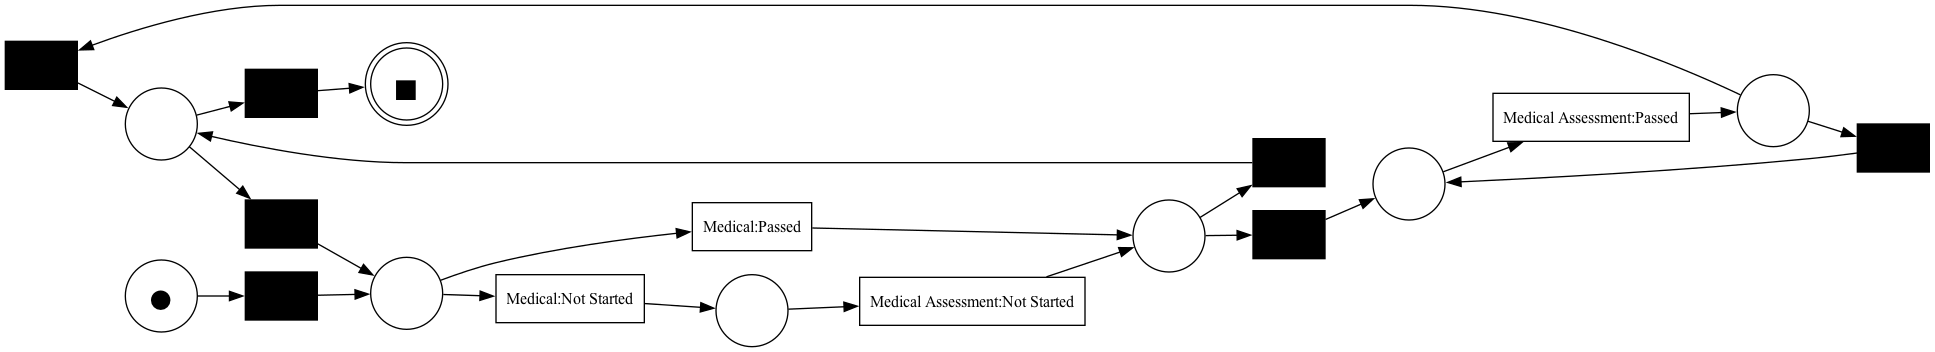

In [7]:
from mine_utils import mine_induct
mine_induct(log2)

In [11]:
itemset = log2['concept:name'].unique()

from mine_utils import aggregate_events

max_timedelta = 10 * 60 # * pow(10,9) # nano to seconds
log3 = aggregate_events(log2, itemset, max_timedelta)

5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
# groups: 2044 total size: 6840 avg size: 3.35
# groups: 2044 # simult: 1951 avg: 95.45 %
# groups: 2044 avg_diff: 26615 s ( 443 m )


In [8]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log2)
var_stats

,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Medical:Not Started, Medical Assessment:Not Started, Medical:Passed, Medical Assessment:Passed)",1350,66.864785,66.864785,11.111111
1,"(Medical:Passed, Medical Assessment:Passed)",627,31.054978,97.919762,22.222222
2,"(Medical:Not Started, Medical Assessment:Not Started)",17,0.842001,98.761763,33.333333
3,"(Medical:Not Started, Medical Assessment:Not Started, Medical:Not Started, Medical Assessment:Not Started, Medical:Passed, Medical Assessment:Passed)",11,0.544824,99.306587,44.444444
4,"(Medical:Not Started, Medical Assessment:Not Started, Medical:Passed, Medical Assessment:Passed, Medical Assessment:Passed)",5,0.247647,99.554235,55.555556
5,"(Medical:Not Started, Medical Assessment:Not Started, Medical:Passed, Medical Assessment:Passed, Medical:Passed, Medical Assessment:Passed)",4,0.198118,99.752353,66.666667
6,"(Medical:Not Started, Medical Assessment:Not Started, Medical:Passed, Medical Assessment:Passed, Medical:Not Started, Medical Assessment:Not Started, Medical:Passed, Medical Assessment:Passed)",3,0.148588,99.900941,77.777778
7,"(Medical:Not Started, Medical Assessment:Not Started, Medical:Passed, Medical Assessment:Passed, Medical:Not Started, Medical Assessment:Not Started, Medical Assessment:Passed)",1,0.049529,99.950471,88.888889
8,"(Medical:Passed, Medical Assessment:Passed, Medical:Not Started, Medical Assessment:Not Started, Medical:Passed, Medical Assessment:Passed)",1,0.049529,100.000000,100.000000


In [ ]:
# does not consider multiple "groups" occurring per case

# max_time_delta = 10 * 60 * pow(10,9) # nano to seconds

# for idx, row in itemsets.iterrows():
#     itemset = row['itemsets']
#     print("itemset:", itemset)
    
#     # filter events to those in the itemset
#     log3 = log2[log2['concept:name'].isin(itemset)]
    
#     # per case, get time differences between itemset events
#     time_diff = log3.groupby('case:concept:name')['time:timestamp'].diff().astype(int)
#     # get those less than the max time delta
#     simult_evts = time_diff[(time_diff >= 0) & (time_diff <= max_time_delta)]
    
#     print("total # events:", log3.shape[0])
#     print("# simult evts:", len(simult_evts), "(", round(len(simult_evts)/log3.shape[0]*100, 2), "%)")
    
#     print()

### Criminality

In [14]:
log2 = log[log['concept:name'].str.contains("Criminality")]
log2

,Unnamed: 0,case:concept:name,concept:name,time:timestamp
3,3,1,Criminality:start,2024-06-03 09:20:39.023
4,4,1,Criminality Assessment:start,2024-06-03 09:20:39.160
31,31,1,Criminality:end,2024-06-30 00:45:58.623
32,32,1,Criminality Assessment:end,2024-06-30 00:45:58.793
43,82,100,Criminality:start,2024-06-03 11:51:35.130
...,...,...,...,...
244761,328768,997,Criminality Assessment:end,2024-06-30 16:00:39.843
244770,328777,998,Criminality:start,2024-06-04 05:51:42.913
244771,328778,998,Criminality Assessment:start,2024-06-04 05:51:43.060
244796,328803,998,Criminality:end,2024-06-04 05:52:32.433


In [15]:
import pm4py.objects.log.exporter.xes.exporter as xes_export
xes_export.apply(log2, "zoom-criminality-all.xes") 
# replace: 
# value="([A-Z])(.*):(.*)"
# value="$1$2 - $3"

exporting log, completed traces ::   0%|          | 0/5429 [00:00<?, ?it/s]

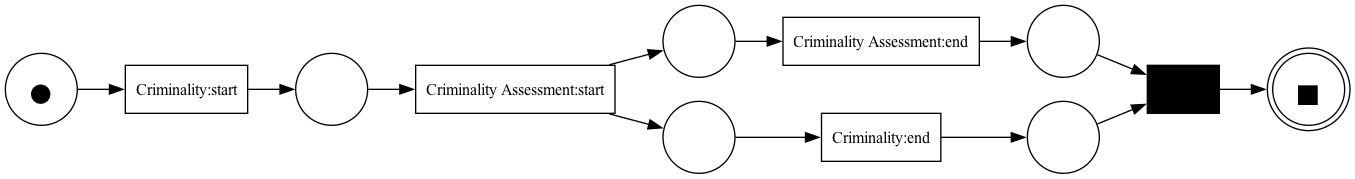

In [16]:
from mine_utils import mine_induct
mine_induct(log2)

In [17]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log2)
var_stats

,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Criminality:start, Criminality Assessment:start, Criminality:end, Criminality Assessment:end)",5428,99.98158,99.98158,50.0
1,"(Criminality:start, Criminality Assessment:start, Criminality Assessment:end, Criminality:end)",1,0.01842,100.00000,100.0


In [21]:
vars = get_covering_variants(99.99, var_stats)
log3 = filter_traces_on_variants(log2, vars)
log3

,case:concept:name,concept:name,time:timestamp
0,1,Criminality:start,2024-06-03 09:20:39.023
1,1,Criminality Assessment:start,2024-06-03 09:20:39.160
2,1,Criminality:end,2024-06-30 00:45:58.623
3,1,Criminality Assessment:end,2024-06-30 00:45:58.793
4,100,Criminality:start,2024-06-03 11:51:35.130
...,...,...,...
21711,997,Criminality Assessment:end,2024-06-30 16:00:39.843
21712,998,Criminality:start,2024-06-04 05:51:42.913
21713,998,Criminality Assessment:start,2024-06-04 05:51:43.060
21714,998,Criminality:end,2024-06-04 05:52:32.433


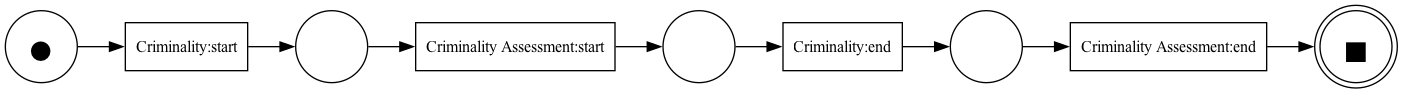

In [22]:
from mine_utils import mine_induct
mine_induct(log3)

## Method 1: simult - frequent

In [ ]:
simult_evts = log.groupby(['case:concept:name', 'time:timestamp'])['concept:name'].apply(tuple)
simult_evts = simult_evts[map(lambda s: len(s)>1, simult_evts)]
simult_evts

In [ ]:
simult_evts.index = simult_evts.index.droplevel(level='time:timestamp')
simult_evts

In [ ]:
simult_evts_list = simult_evts.groupby(level=0).apply(tuple).to_list()
simult_evts_list[0]

In [ ]:
simult_evts[simult_evts.index=="1"]

In [ ]:
log[log['case:concept:name']=="1"]

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(simult_evts_list).transform(simult_evts_list)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

itemsets = apriori(df, min_support=0.1, use_colnames=True)
itemsets.sort_values(by='support', ascending=False).to_csv("tmp.csv")

In [ ]:
rules = association_rules(itemsets, metric ="lift", min_threshold = 1)
rules.sort_values(by='confidence', ascending=False)